In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from pprint import pprint

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import matplotlib.gridspec as gridspec

import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)


PyTables is not installed. No support for HDF output.


In [2]:
hfp_fi = '../hfp-global-geo-grid/hf_v2geo_1_0deg.tif'
hfp_fi = '../hfp-global-geo-grid/hf_v2geo_0_25deg.tif'
with rio.open(hfp_fi) as src:
    hfp_prof = src.profile
    hfp_arr = src.read(1)
    hfp_arr = np.ma.masked_less(hfp_arr, 0)
    
print(hfp_prof)
xr_hfp = xr.open_rasterio(hfp_fi)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1440, 'height': 620, 'count': 1, 'crs': CRS.from_dict(init='epsg:4008'), 'transform': Affine(0.2499999, 0.0, -180.0,
       0.0, -0.2499999, 89.76428993520813), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


In [3]:
raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
raster_folder = r"../vars/CSV_nocorn_grid_0_25_degree_vars/" # data refresh! fixed mis classifications
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

In [4]:
# open and resample to 2.5 deg res
from skimage.transform import resize

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    op_0_25_prof = src.profile

with rio.open('../overpass_corrections/2003-2018_day_overpass-count.tif') as src:
    day_op = src.read()
    day_op = np.ma.masked_equal(day_op, 0)
    
with rio.open('../overpass_corrections/2003-2018_night_overpass-count.tif') as src:
    night_op = src.read()
    night_op = np.ma.masked_equal(night_op, 0)


In [5]:
# account for the updated overpass corrections with month-year combos
month_dict = {'January': '01',
             'February': '02',
             'March': '03',
             'April': '04',
             'May': '05',
             'June': '06',
             'July': '07',
             'August': '08',
             'September':'09',
             'October':'10',
             'November': '11',
             'December':'12'}

days_fl, nights_fl=[],[]
day_an, night_an = [],[]
day_op_stack, night_op_stack = [],[]
agg = 4
op_dir = '../overpass_corrections/year-month'
for year in range(2003,2019):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
    
    ds = np.ma.sum(day_arr, axis=0) #*op_oc
    ns = np.ma.sum(night_arr, axis=0) #*op_oc
    
    day_an.append(ds[np.newaxis,...])
    night_an.append(ns[np.newaxis, ...])
    
    
    # overpass rasters
    day_op_ls = [os.path.join(op_dir,'{}-{}_day_overpass-count.tif'.format(year,month_dict[os.path.basename(fi).split('_')[-2]])) for fi in day_files]
    night_op_ls = [os.path.join(op_dir,'{}-{}_night_overpass-count.tif'.format(year,month_dict[os.path.basename(fi).split('_')[-2]])) for fi in night_files]
    
    day_op_arr,_ = es_stack(day_op_ls, nodata=0)
    night_op_arr, _ = es_stack(night_op_ls, nodata=0)
    
    day_op_sum = np.ma.sum(day_op_arr, axis=0)
    night_op_sum = np.ma.sum(night_op_arr, axis=0)
    
    day_op_stack.append(day_op_sum[np.newaxis,...])
    night_op_stack.append(night_op_sum[np.newaxis,...])
    
    

In [6]:
day_sum = np.ma.concatenate(day_an, axis=0)
print(day_sum.shape)
day_sum = np.ma.sum(day_sum, axis=0)
night_sum = np.ma.concatenate(night_an, axis=0)
night_sum = np.ma.sum(night_sum, axis=0)

# full record overpass
day_sum /= day_op[0]
night_sum /= night_op[0]

perc_day_total = day_sum / (day_sum + night_sum)
perc_night_total = night_sum / (day_sum + night_sum)

(16, 721, 1440)


In [7]:
tform = op_0_25_prof['transform']
ncols = op_0_25_prof['width']
nrows = op_0_25_prof['height']
agg_fact=1 # 0.25 degree

# template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
# with rio.open(template) as src:
#     meta = src.meta

# tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = night_sum.shape[1]
num_y = night_sum.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)

In [8]:
# make data into xarray with location
xr_nightsum = xr.DataArray(night_sum, coords=[tlat, tlon], dims=['x', 'y'])
xr_nightsum = xr.where(xr_nightsum == 0, np.nan, xr_nightsum)

# make data into xarray with location
xr_daysum = xr.DataArray(day_sum, coords=[tlat, tlon], dims=['x', 'y'])
xr_daysum = xr.where(xr_daysum == 0, np.nan, xr_daysum)

In [9]:
night_sum.shape

(721, 1440)

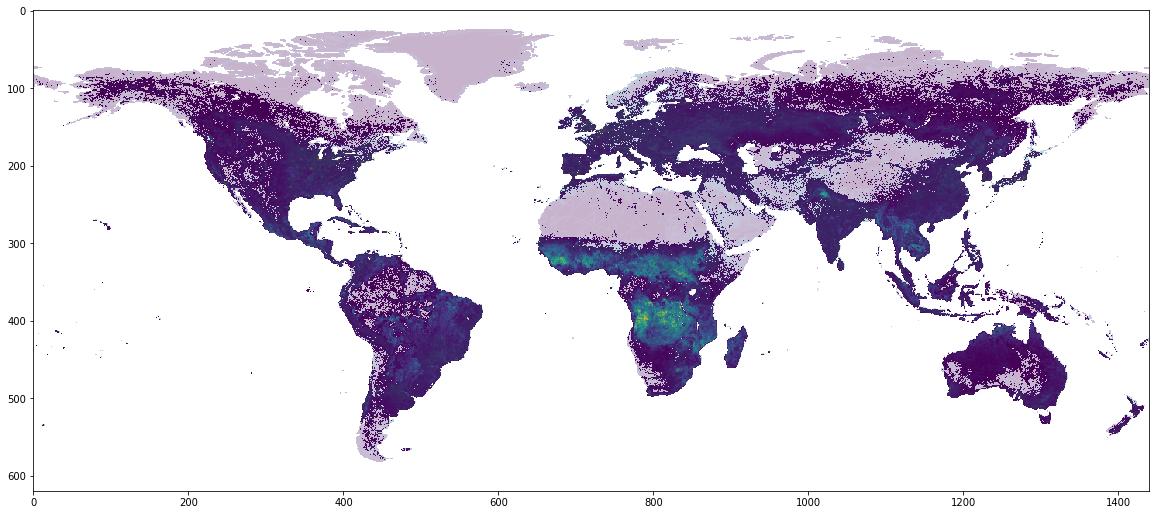

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(xr_daysum.values[:620,:])
plt.imshow(hfp_arr, alpha=0.3)
plt.show()

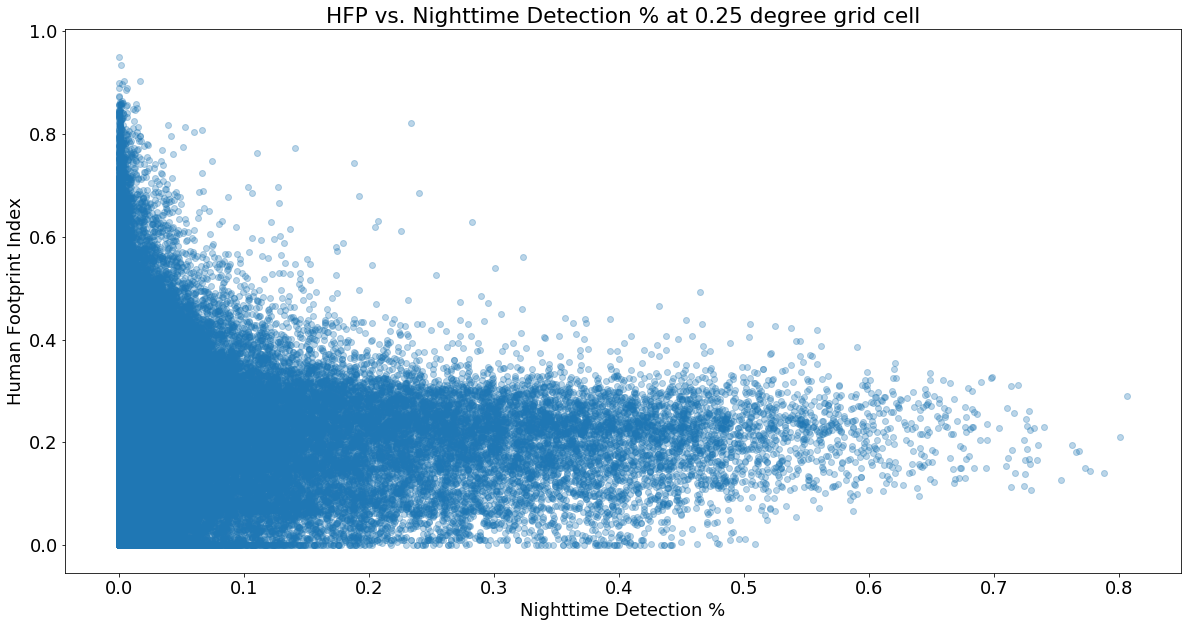

In [11]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# do a scatter plot at 0.25 degree
x = xr_daysum.values[:620,:].ravel()
y = hfp_arr.ravel()/100
plt.figure(figsize=(20,10))
plt.scatter(x,y, alpha=0.3)
plt.ylabel('Human Footprint Index')
plt.xlabel('Nighttime Detection %')
plt.title('HFP vs. Nighttime Detection % at 0.25 degree grid cell')
plt.savefig('../hfp-global-geo-grid/hfp_scatter_nperc_0_25deg.png')
plt.show()

75401 75401
14673 14673
1616 1616
129 129


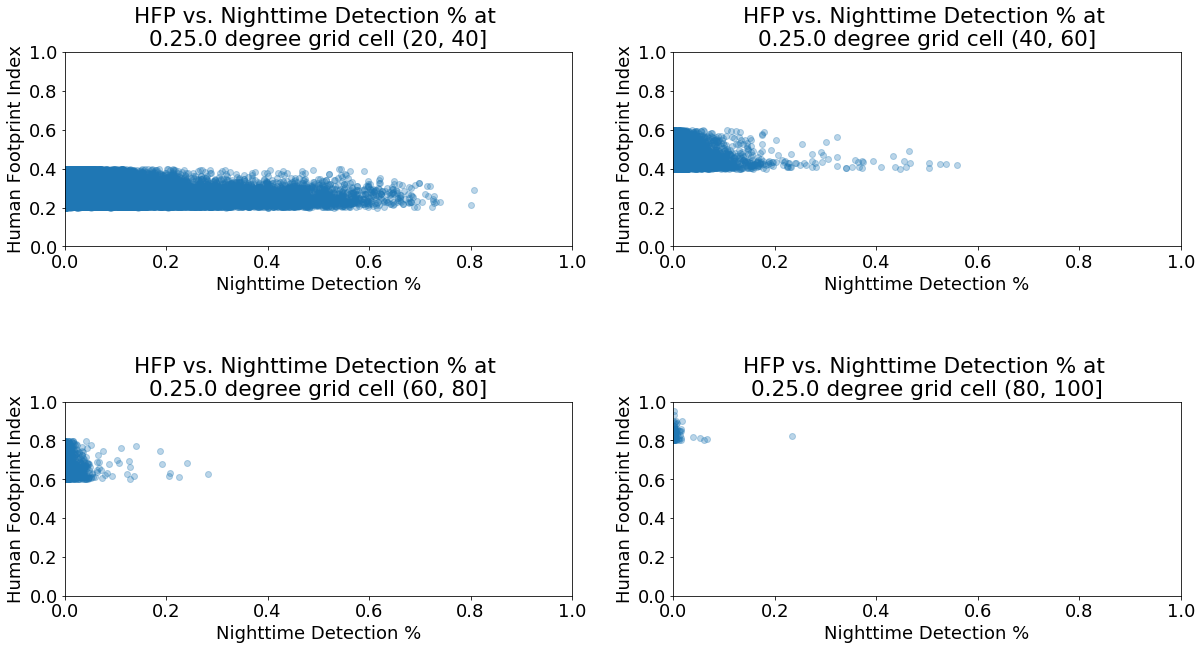

In [12]:
unit = 20
fig, axes = plt.subplots(2,2, figsize=(20,10))
for i,ax in zip(range(20,100,unit), axes.ravel()):
    # do a scatter plot at 1.0 degree
    x = xr_daysum.values[:620,:].ravel()
    y = hfp_arr.ravel()
    
    x = x[(y>i) & (y<=i+unit)]
    y = y[(y>i) & (y<=i+unit)]/100
        
    print(x.size, y.size)
    
    ax.scatter(x,y, alpha=0.3)
    ax.set_ylabel('Human Footprint Index')
    ax.set_xlabel('Nighttime Detection %')
    ax.set_title('HFP vs. Nighttime Detection % at \n0.25.0 degree grid cell ({}, {}]'.format(i, i+unit))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    #

plt.subplots_adjust(hspace=0.8)
plt.savefig('../hfp-global-geo-grid/hfp_subplots_scatter_nperc_0_25deg.png')
plt.show()

In [13]:
nightagg_file = r'D:\projects\RD\night_fire\figs\global\AGG_1deg_SOLARELEV_nocorn_perc_night_total.tif'
with rio.open(nightagg_file) as src:
    nightagg_arr = src.read()
    nightagg_arr = np.ma.masked_equal(nightagg_arr, -32768.0)
    print(src.profile)



hfp_fi1 = '../hfp-global-geo-grid/hf_v2geo_1_0deg.tif'
with rio.open(hfp_fi1) as src:
    hfp1_prof = src.profile
    hfp1_arr = src.read(1)
    hfp1_arr = np.ma.masked_less(hfp1_arr, 0)
    
print(hfp1_prof)
xr_hfp1 = xr.open_rasterio(hfp_fi1)
print(nightagg_arr.shape, hfp1_arr.shape)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 360, 'height': 180, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(1.0, 0.0, -179.625,
       0.0, -1.0, 89.625), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 360, 'height': 155, 'count': 1, 'crs': CRS.from_dict(init='epsg:4008'), 'transform': Affine(0.9999996, 0.0, -180.0,
       0.0, -0.9999996, 89.76428993520813), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}
(1, 180, 360) (155, 360)


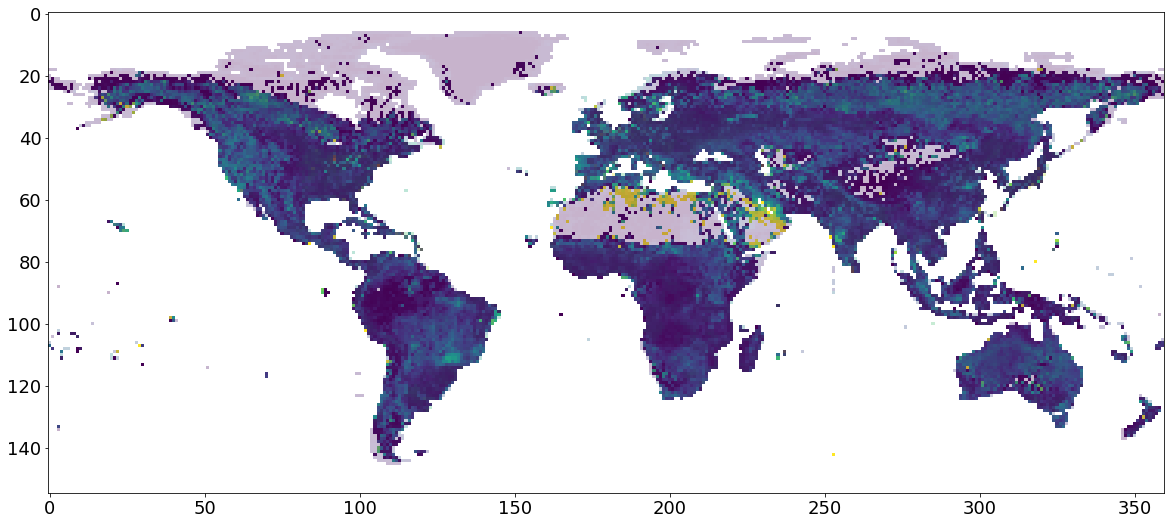

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(nightagg_arr[0,:155,:])
plt.imshow(hfp1_arr, alpha=0.3)
plt.show()

55800 55800


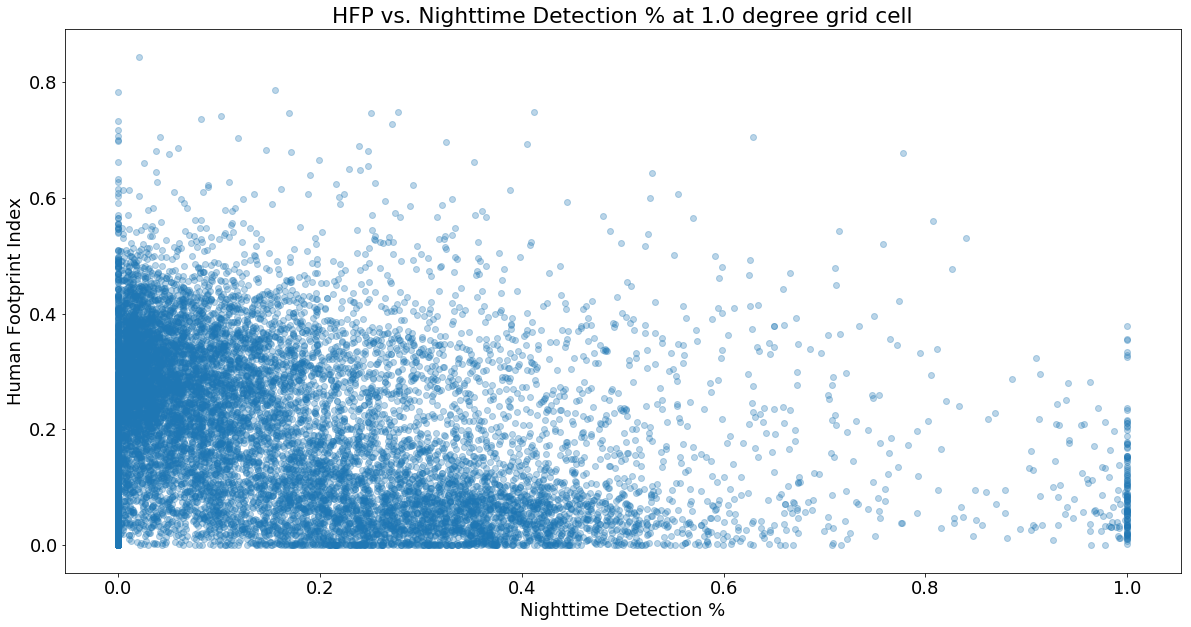

In [15]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# do a scatter plot at 1.0 degree
x1 = nightagg_arr[0,:155,:].ravel()
y1 = hfp1_arr.ravel()/100
print(x1.size, y1.size)
plt.figure(figsize=(20,10))
plt.scatter(x1,y1, alpha=0.3)
plt.ylabel('Human Footprint Index')
plt.xlabel('Nighttime Detection %')
plt.title('HFP vs. Nighttime Detection % at 1.0 degree grid cell')
plt.savefig('../hfp-global-geo-grid/hfp_scatter_nperc_1_0deg.png')
plt.show()

5662 5662
1059 1059
72 72
2 2


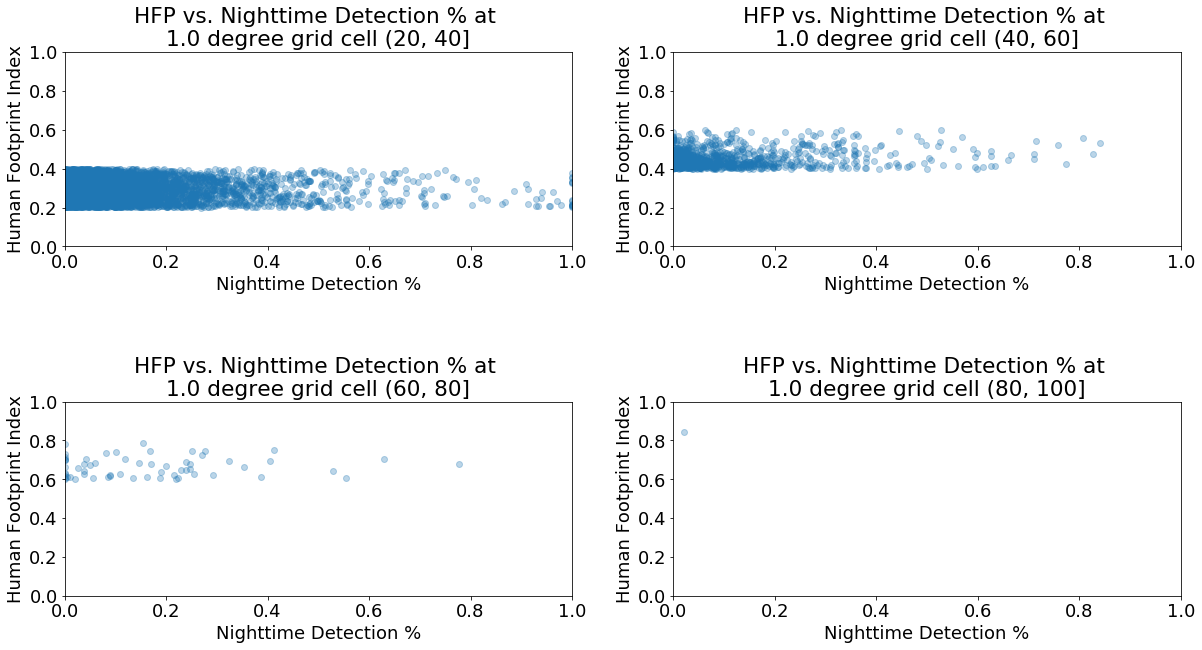

In [16]:
unit = 20
fig, axes = plt.subplots(2,2, figsize=(20,10))
for i,ax in zip(range(20,100,unit), axes.ravel()):
    # do a scatter plot at 1.0 degree
    x1 = nightagg_arr[0,:155,:].ravel()
    y1 = hfp1_arr.ravel()
    
    x1 = x1[(y1>i) & (y1<=i+unit)]
    y1 = y1[(y1>i) & (y1<=i+unit)]/100
    
    
    print(x1.size, y1.size)
    
    ax.scatter(x1,y1, alpha=0.3)
    ax.set_ylabel('Human Footprint Index')
    ax.set_xlabel('Nighttime Detection %')
    ax.set_title('HFP vs. Nighttime Detection % at \n1.0 degree grid cell ({}, {}]'.format(i, i+unit))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    #

plt.subplots_adjust(hspace=0.8)
plt.savefig('../hfp-global-geo-grid/hfp_subplots_scatter_nperc_1_0deg.png')
plt.show()

Summarize by 11 landcovers

In [17]:
gldas_fi = '../GLDAS/GLDASp4_domveg_025d.tif'
with rio.open(gldas_fi) as src:
    gldas_prof = src.profile
    gldas_arr = src.read(1)
    
xr_gldas = xr.open_rasterio(gldas_fi)

In [18]:
gldas_arr.shape, hfp_arr.shape

((600, 1440), (620, 1440))

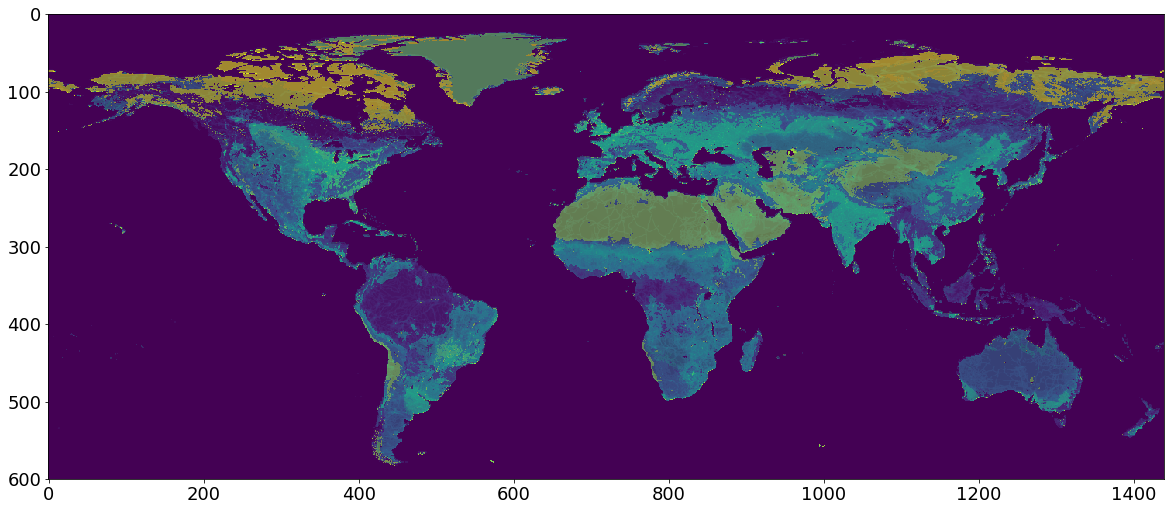

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(gldas_arr)
plt.imshow(hfp_arr[:600,:], alpha=0.4)
plt.show()

In [27]:
# Max's palette
gldas_burn_cond = (gldas_arr==0) | (gldas_arr==3) | (gldas_arr==11) | (gldas_arr==13) | (gldas_arr>=15)

# gldas_mask = np.where((gldas_arr==0) | (gldas_arr==12) | (gldas_arr==14), 0, 1)
gldas_mask = np.where(gldas_burn_cond, 0, 1)


In [28]:
# masked gldas_arr
temp = gldas_arr*gldas_mask
np.unique(temp)

array([ 0.,  1.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 14.])

In [29]:
# mask the human footprint array for each land cover
hfp_dict = {}
for v in np.unique(temp):
    if v == 0: continue
    
    
    masked_hfp = hfp_arr[:600,:][gldas_arr==v]
    hfp_dict[int(v)] = masked_hfp.mean()

hfp_dict

{1: 9.931397021492637,
 2: 16.603638055592263,
 4: 27.15276319159836,
 5: 21.6169139243755,
 6: 16.981418399360237,
 7: 10.766583362721429,
 8: 21.74753743820878,
 9: 21.16807162010726,
 10: 19.799977735783482,
 12: 35.93301045690429,
 14: 33.29074296652421}

In [30]:
gldas_labels = ['missing value',
               'Evergreen Needleleaf Forest',
               'Evergreen Broadleaf Forest',
               'Deciduous Needleleaf Forest',
               'Deciduous Broadleaf Forest',
               'Mixed Forest',
               'Closed Shrublands',
               'Open Shrublands',
               'Woody Savannas',
               'Savannas',
               'Grassland',
               'Permanent Wetland',
               'Cropland',
               'Urban and Built-Up',
               'Cropland / Natural Vegetation Mosaic',
               'Snow and Ice', 
               'Barren or Sparsely Vegetated',
               'Ocean',
               'Wooded Tundra',
               'Mixed Tundra',
               'Bare Ground Tundra']

hfp_label_values = [gldas_labels[i] for i in hfp_dict.keys()]

In [33]:
pd.DataFrame({'GLDAS_label':hfp_label_values,
              'GLDAS_val':list(hfp_dict.keys()),
             'HFP_mean':list(hfp_dict.values())})

,GLDAS_label,GLDAS_val,HFP_mean
0,Evergreen Needleleaf Forest,1,9.931397
1,Evergreen Broadleaf Forest,2,16.603638
2,Deciduous Broadleaf Forest,4,27.152763
3,Mixed Forest,5,21.616914
4,Closed Shrublands,6,16.981418
5,Open Shrublands,7,10.766583
6,Woody Savannas,8,21.747537
7,Savannas,9,21.168072
8,Grassland,10,19.799978
9,Cropland,12,35.933010


In [339]:
gl_day = xr_daysum.values[:600,:]
gl_night = xr_nightsum.values[:600,:]

daysum_list, nightsum_list, nightperc_list, cts_list = [],[], [], []
for v in np.unique(gldas_arr):
    
    dsum = np.nansum(np.where(gldas_arr==v, gl_day, np.nan))
    daysum_list.append(dsum)
    
    nsum = np.nansum(np.where(gldas_arr==v, gl_night, np.nan))
    nightsum_list.append(nsum)
    
    nightperc_list.append(nsum / (nsum+dsum))
    
    cts_list.append((gldas_arr==v).sum())

In [340]:
# Index	Vegetation Type
# 0	missing value
# 1	Evergreen Needleleaf Forest 
# 2	Evergreen Broadleaf Forest
# 3	Deciduous Needleleaf Forest 
# 4	Deciduous Broadleaf Forest
# 5	Mixed Forest 
# 6	Closed Shrublands 
# 7	Open Shrublands 
# 8	Woody Savannas
# 9	Savannas
# 10	Grassland
# 11	Permanent Wetland
# 12	Cropland
# 13	Urban and Built-Up
# 14	Cropland/Natural Vegetation Mosaic
# 15	Snow and Ice 
# 16	Barren or Sparsely Vegetated 
# 17	Ocean 
# 18	Wooded Tundra 
# 19	Mixed Tundra 
# 20	Bare Ground Tundra 

gldas_labels = ['missing value',
               'Evergreen Needleleaf Forest',
               'Evergreen Broadleaf Forest',
               'Deciduous Needleleaf Forest',
               'Deciduous Broadleaf Forest',
               'Mixed Forest',
               'Closed Shrublands',
               'Open Shrublands',
               'Woody Savannas',
               'Savannas',
               'Grassland',
               'Permanent Wetland',
               'Cropland',
               'Urban and Built-Up',
               'Cropland / Natural Vegetation Mosaic',
               'Snow and Ice', 
               'Barren or Sparsely Vegetated',
               'Ocean',
               'Wooded Tundra',
               'Mixed Tundra',
               'Bare Ground Tundra']
len(gldas_labels)

21

In [341]:
gldas_dict = {'gldas_label':gldas_labels, 
              'daysum':daysum_list, 
              'nightsum':nightsum_list, 
              'gldas_counts':cts_list, 
              'night_perc':nightperc_list}
gldas_summary = pd.DataFrame(gldas_dict)
# gldas_summary = pd.DataFrame(data=[gldas_labels, daysum_list, nightsum_list, cts_list, nightperc_list],
#                             columns=['gldas_label', 'daysum', 'nightsum', 'gldas_counts', 'night_perc'])

In [342]:
gldas_summary.to_csv('../GLDAS/gldas_025_summary_oc_full.csv')

In [347]:
gldas_summary.iloc[1:].sort_values('night_perc')
gldas_summary.iloc[1:]
gldas_summary.iloc[[ 1,  2,  4,  5,  6,  7,  8,  9, 10, 12, 14]]

,gldas_label,daysum,nightsum,gldas_counts,night_perc
1,Evergreen Needleleaf Forest,53.724228,26.124821,17787,0.327178
2,Evergreen Broadleaf Forest,1083.965088,140.393707,22879,0.114667
4,Deciduous Broadleaf Forest,120.295937,12.335710,2443,0.093007
5,Mixed Forest,136.986694,20.629423,17563,0.130884
6,Closed Shrublands,2.035363,0.728401,255,0.263554
7,Open Shrublands,229.134735,68.197479,37038,0.229365
8,Woody Savannas,1574.133057,98.693268,6880,0.058998
9,Savannas,1657.650757,154.054092,12497,0.085033
10,Grassland,318.557831,48.709740,23041,0.132627
12,Cropland,430.406677,40.393314,25700,0.085797


In [357]:
gldas_summary[1:]

,gldas_label,daysum,nightsum,gldas_counts,night_perc
1,Evergreen Needleleaf Forest,53.724228,26.124821,17787,0.327178
2,Evergreen Broadleaf Forest,1083.965088,140.393707,22879,0.114667
3,Deciduous Needleleaf Forest,17.674278,6.618279,4074,0.272441
4,Deciduous Broadleaf Forest,120.295937,12.335710,2443,0.093007
5,Mixed Forest,136.986694,20.629423,17563,0.130884
6,Closed Shrublands,2.035363,0.728401,255,0.263554
7,Open Shrublands,229.134735,68.197479,37038,0.229365
8,Woody Savannas,1574.133057,98.693268,6880,0.058998
9,Savannas,1657.650757,154.054092,12497,0.085033
10,Grassland,318.557831,48.709740,23041,0.132627


In [359]:
nc_df = gldas_summary.iloc[1:][~gldas_summary['gldas_label'].str.contains('Cropland')]
nc_df = gldas_summary.iloc[[ 1,  2,  4,  5,  6,  7,  8,  9, 10, 12, 14]] #MAx's analysis
# nc_df = gldas_summary.iloc[[ 1,  2,  4,  5,  6,  7,  8,  9, 10]]
burnable_night_perc = nc_df['nightsum'].sum() / (nc_df['nightsum'].sum() + nc_df['daysum'].sum())

print(f'burnable lands excluding cropland: {burnable_night_perc}')

burnable lands excluding cropland: 0.09854383579875338


### calculate burnable lands summary per year

In [119]:
gldas_burn_cond = (gldas_arr==0) | \
             (gldas_arr==13) | (gldas_arr==15) | (gldas_arr==16) | (gldas_arr == 17) | \
             (gldas_arr==18) | (gldas_arr==19) | (gldas_arr==20) 
        
# gldas_mask = np.where((gldas_arr==0) | (gldas_arr==12) | (gldas_arr==14), 0, 1)
gldas_mask = np.where(gldas_burn_cond, 0, 1)

In [120]:
gldas_mask.shape

(600, 1440)

In [121]:
day_an[0].shape

(1, 721, 1440)

In [122]:
years = np.arange(2003,2019,1)
years

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018])

In [123]:
day_perc, night_perc = [],[]

for y,d,n in zip(years,day_an,night_an):
    
    d=d[0,:600,:] * gldas_mask
    n=n[0,:600,:] * gldas_mask
    d_p = d.sum() / (d.sum() +n.sum())
    n_p = n.sum() / (d.sum() + n.sum())
    
    day_perc.append(d_p)
    night_perc.append(n_p)
    
np.mean(day_perc), np.std(day_perc), np.mean(night_perc), np.std(night_perc)

(0.8925508104116398,
 0.009714531927506721,
 0.10744918958836022,
 0.00971453192750671)

calculate per GLDAS class

In [356]:
# construct landcover dictionary
lc_dict = {}
for v in np.unique(gldas_arr):
    lc_dict[v] = None


daysum_list, nightsum_list, nightperc_list, cts_list = [],[], [], []
ix=0
for v in np.unique(gldas_arr):
    
    df_list = []
    for y,d,n,d_op,n_op in zip(years,day_an,night_an, day_op_stack, night_op_stack): 
    
        
        d=d[0,:600,:] / d_op[0,:600,:]
        n=n[0,:600,:] / n_op[0,:600,:]
        _d = np.where(gldas_arr==v, d, np.nan)
        dsum = np.nansum(_d)
        daysum_list.append(dsum)

        _n = np.where(gldas_arr==v, n, np.nan)
        nsum = np.nansum(_n)
        nightsum_list.append(nsum)

        nightperc_list.append(nsum / (nsum+dsum))

        cts_list.append((gldas_arr==v).sum())
        
        nval = nsum / (nsum+dsum)
        nstd = np.nanstd(_n / (_n + _d))
        #print(f'Landcover {gldas_labels[ix]}, year {y}: night % {nval}, std {nstd}')
        
    
        df_list.append([gldas_labels[ix], year, nval, nstd])
        
    lc_dict[ix] = pd.DataFrame(np.array(df_list), columns=['landcover', 'year', 'night_perc', 'night_std'])
    
    # write to file
    lc_name = gldas_labels[ix].replace('/','').replace('  ', ' ').replace(' ','_')
    csv_path = os.path.join(f'../GLDAS/GLDAS_LC_{lc_name}_full.csv')
    lc_dict[ix].to_csv(csv_path)
    ix+=1

{1: '#006400', 2: '#228B22', 3: '#458B00', 4: '#008B45', 5: '#3CB371', 6: '#6E8B3D', 7: '#9ACD32', 8: '#6B8E23', 9: '#8B8B00', 10: '#CDC673', 11: '#00868B', 12: '#EE9572', 14: '#EE8262'}


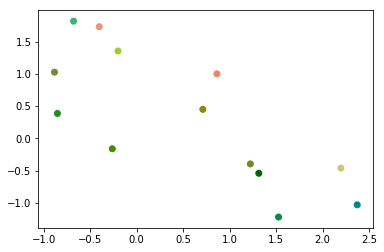

In [126]:
# test_colors = (("Evergreen Needleleaf Forests","darkgreen"),
#                 ("Evergreen Broadleaf Forests" , "forestgreen"),
#                 ("Deciduous Needleleaf Forests", "chartreuse4"),
#                 ("Deciduous Broadleaf Forests", "springgreen4"),
#                 ("Mixed Forests", "mediumseagreen"),
#                 ("Closed Shrublands" , "darkolivegreen4"),
#                 ("Open Shrublands" , "olivedrab3"),
#                 ("Woody Savannas" , "olivedrab"),
#                 ("Savannas" , "yellow4"),
#                 ("Grasslands" , "khaki3"),
#                 ("Permanent Wetlands" , "turquoise4"),
#                 ("Croplands" , "lightsalmon2"),
#                 ("Urban and Built-up Lands" , "gray70"),
#                 ("Cropland/Natural  Vegetation  Mosaics" , "salmon2"),
#                 ("Permanent Snow and Ice" , "white"),
#                 ("Barren" , "burlywood"),
#                 ("Water Bodies" , "skyblue"),
#                 ("Unclassified" , "gray")
#                 )

test_colors = {"Evergreen Needleleaf Forest" : "#006400",
                "Evergreen Broadleaf Forest" : "#228B22",
                "Deciduous Needleleaf Forest": "#458B00",
                "Deciduous Broadleaf Forest" : "#008B45",
                "Mixed Forest": "#3CB371",
                "Closed Shrublands" : "#6E8B3D",
                "Open Shrublands" : "#9ACD32",
                "Woody Savannas" : "#6B8E23",
                "Savannas" : "#8B8B00",
                "Grassland" : "#CDC673",
                "Permanent Wetland" : "#00868B",
                "Cropland" : "#EE9572",
                "Urban and Built-Up" : "#B3B3B3",
                "Cropland / Natural Vegetation Mosaic" : "#EE8262",
                "Snow and Ice" : "#FFFFFF",
                "Barren or Sparsely Vegetated" : "#DEB887",
                "Ocean" : "#87CEEB",
                "Unclassified" : "#BEBEBE"
              }

test_colors = {"Evergreen Needleleaf Forest" : "#006400",
                "Evergreen Broadleaf Forest" : "#228B22",
                "Deciduous Needleleaf Forest": "#458B00",
                "Deciduous Broadleaf Forest" : "#008B45",
                "Mixed Forest": "#3CB371",
                "Closed Shrublands" : "#6E8B3D",
                "Open Shrublands" : "#9ACD32",
                "Woody Savannas" : "#6B8E23",
                "Savannas" : "#8B8B00",
                "Grassland" : "#CDC673",
                "Permanent Wetland" : "#00868B",
                "Cropland" : "#EE9572",
                "Urban and Built-Up" : "#B3B3B3",
                "Cropland / Natural Vegetation Mosaic" : "#EE8262",
                "Snow and Ice" : "#FFFFFF",
                "Barren or Sparsely Vegetated" : "#DEB887"
              }


In [127]:
gldas_burnable = np.where(gldas_burn_cond | (gldas_arr==17), np.nan, gldas_arr)
uniq_burn = np.unique(gldas_burnable[~np.isnan(gldas_burnable)])
burnable_labels = [gldas_labels[int(_)] for _ in uniq_burn]
burnable_labels

['Evergreen Needleleaf Forest',
 'Evergreen Broadleaf Forest',
 'Deciduous Needleleaf Forest',
 'Deciduous Broadleaf Forest',
 'Mixed Forest',
 'Closed Shrublands',
 'Open Shrublands',
 'Woody Savannas',
 'Savannas',
 'Grassland',
 'Permanent Wetland',
 'Cropland',
 'Cropland / Natural Vegetation Mosaic']

{1: '#006400', 2: '#228B22', 3: '#458B00', 4: '#008B45', 5: '#3CB371', 6: '#6E8B3D', 7: '#9ACD32', 8: '#6B8E23', 9: '#8B8B00', 10: '#CDC673', 11: '#00868B', 12: '#EE9572', 13: '#B3B3B3'}


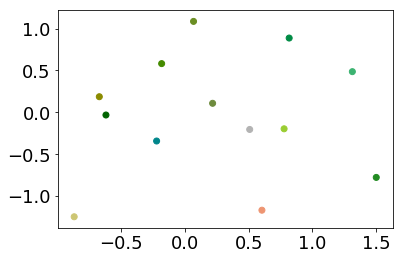

In [313]:
colors_dict = {}
for v in np.unique(uniq_burn):
    if v==0:
        colors_dict[int(v)] = test_colors['Unclassified']
    else:
        colors_dict[int(v)] = test_colors[gldas_labels[int(v)]]
    
print(colors_dict)
test_c = [_ for _ in colors_dict.values()]
_ar = np.random.randn(len(test_c),2)


plt.scatter(_ar[:,0], _ar[:,1], c=test_c)

[ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


(None, None)

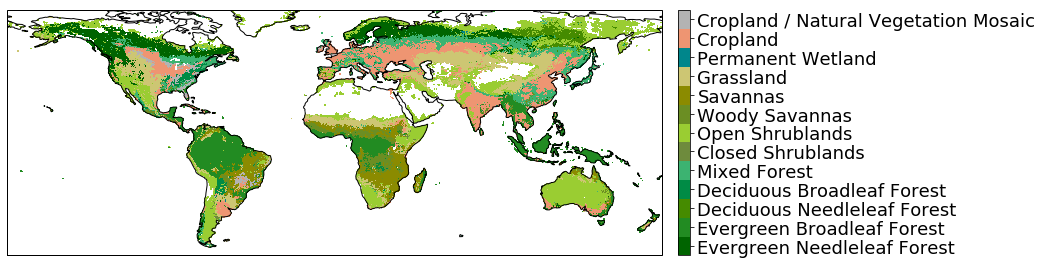

In [315]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

colors = test_c
cmap = matplotlib.colors.ListedColormap(colors)
bounds = uniq_burn
# bounds[-1] = 13
bounds_labels = burnable_labels
# bounds = [-600] + bounds + [600]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

# fig, ax = plt.subplots(figsize=(20,20))
# cf4 = plt.imshow(gldas_burnable, cmap=cmap)

fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
xr_gldas2 = xr_gldas.copy()
xr_gldas2.values = gldas_burnable[np.newaxis,...]
cf4 = xr_gldas2.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, extend='neither')
ax.set_ylim(-60,75)
ax.set_title('')


cb4 = fig.colorbar(cf4, ax=ax, orientation='vertical', shrink=1.0, pad=0.02, 
                   cmap=cmap, 
                   ticks=bounds + .5)
cb4.set_ticklabels(bounds_labels)

print(cb4.get_ticks())

plt.tight_layout()
plt.savefig(r'D:\projects\RD\night_fire\GLDAS\GLDAS_burnable.png')

print(bounds), print(uniq_burn)

'Deciduous Needleleaf Forest'
'Permanent Wetland'

Evergreen Needleleaf Forest
Evergreen Broadleaf Forest
Deciduous Broadleaf Forest
Mixed Forest
Closed Shrublands
Open Shrublands
Woody Savannas
Savannas
Grassland
Cropland
Urban and Built-Up

 11 {1: '#999933', 2: '#117733', 4: '#44AA99', 5: '#661100', 6: '#332288', 7: '#CC6677', 8: '#AA4499', 9: '#882255', 10: '#DDCC77', 12: '#88CCEE', 13: '#6699CC'}


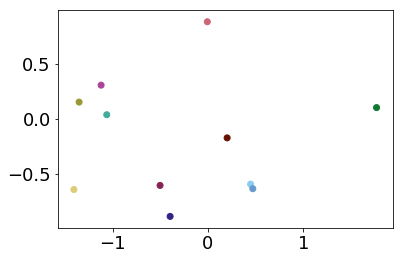

In [323]:
max_dict = {'Closed Shrublands' : '#332288',
            'Cropland / Natural Vegetation Mosaic' : '#6699CC',
            'Cropland' : '#88CCEE',
            'Deciduous Broadleaf Forest' : '#44AA99',
            'Evergreen Broadleaf Forest' : '#117733',
            'Evergreen Needleleaf Forest' : '#999933',
            'Grassland' : '#DDCC77',
            'Mixed Forest' : '#661100',
            'Open Shrublands' : '#CC6677',
            'Savannas' : '#882255',
            'Woody Savannas' : '#AA4499'}


burn_dict = {}
for i,_ in enumerate(uniq_burn):
    burn_dict[int(_)] = burnable_labels[i]
    
colors_dict = {}
labels_dict = {}
ctr=0
for v in uniq_burn:
    try:
        colors_dict[int(v)] = max_dict[burn_dict[int(v)]]
        labels_dict[int(v)] = burn_dict[int(v)]
        ctr +=1
    except Exception as e:
        print(e)
        continue
        
print()
for k in colors_dict.keys():
    print(gldas_labels[k])
    
print('\n',ctr, colors_dict)
test_c = [_ for _ in colors_dict.values()]
_ar = np.random.randn(len(test_c),2)


plt.scatter(_ar[:,0], _ar[:,1], c=test_c)

[ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5]


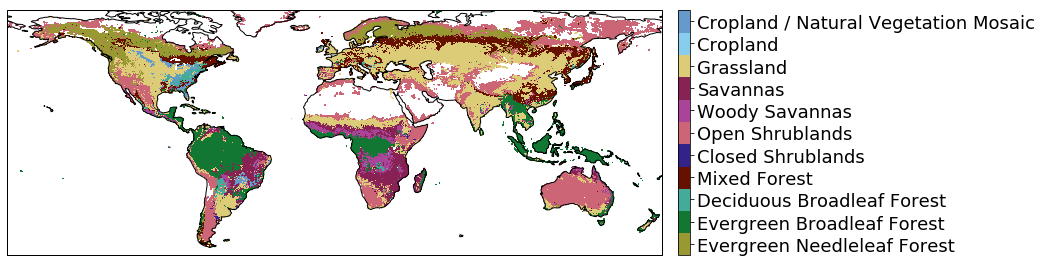

In [326]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

colors = test_c
cmap2 = matplotlib.colors.ListedColormap(colors)
bounds = uniq_burn[(uniq_burn != 3) & (uniq_burn != 11)]
# bounds = np.arange(1,12)
bounds_labels = list(labels_dict.values())
# bounds_labels = list(colors_dict.values())
norm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N, clip=True)

fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
xr_gldas2 = xr_gldas.copy()

# remove classes Max omitted
temp = gldas_burnable[np.newaxis,...]
temp_cond = (gldas_burnable == 3) | (gldas_burnable==11)
temp = np.where(temp_cond, np.nan, temp)
temp2=temp.copy()

# shift values
temp2[(temp>=4) & (temp<=12)] -= 1
temp2[(temp>=12)] -= 2

xr_gldas2.values = temp2
cf4 = xr_gldas2.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap2, add_colorbar=False, extend='neither')
ax.set_ylim(-60,75)
ax.set_title('')


cb4 = fig.colorbar(cf4, ax=ax, orientation='vertical', shrink=1.0, pad=0.02)#, 
                   #cmap=cmap2, 
                   #ticks=bounds + .5)

cb4.set_ticks([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5])
cb4.set_ticklabels(bounds_labels)
print(cb4.get_ticks())


plt.tight_layout()
plt.savefig(r'D:\projects\RD\night_fire\GLDAS\GLDAS_burnable_maxPalette.png')

In [330]:
_x = temp
np.unique(_x[~np.isnan(_x)])

array([ 1.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 14.],
      dtype=float32)

In [311]:
np.arange(1,12)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [240]:
burn_dict

{1: 'Evergreen Needleleaf Forest',
 2: 'Evergreen Broadleaf Forest',
 3: 'Deciduous Needleleaf Forest',
 4: 'Deciduous Broadleaf Forest',
 5: 'Mixed Forest',
 6: 'Closed Shrublands',
 7: 'Open Shrublands',
 8: 'Woody Savannas',
 9: 'Savannas',
 10: 'Grassland',
 11: 'Permanent Wetland',
 12: 'Cropland',
 13: 'Cropland / Natural Vegetation Mosaic'}